In [1]:
import multiprocessing as mp
import subprocess as sp
import tempfile as tmp
from typing import Literal, Optional, Tuple

import pandas as pd
from tqdm import tqdm

In [2]:
df_c = pd.read_pickle('./output/1_df_b_shaders-win-0924.pkl.zstd', compression='zstd')
df_p = pd.read_pickle('../performance/output/df_performance-win-0924.pkl.zstd', compression='zstd')
idx = df_p[df_p['status'] == 'Ok'].index
df = df_c[df_c.index_webapp.isin(idx)].copy()
df['type'] = df['type'].map(lambda x: 'vert' if x > 35632.5 else 'frag')
df.to_pickle('./output/df_shaders_joined-win-0924.pkl.zstd', compression='zstd')

In [3]:
NAGA = '/home/yudonghan/.cargo/bin/naga'
ANGLE = '/home/yudonghan/.local/bin/angle_shader_translator'
SPVAS = '/usr/bin/spirv-as'

In [4]:
def naga_compile(shader: str, type: Literal['vert', 'frag']) -> Tuple[str, bytes, bytes, int, Optional[str]]:
    with tmp.NamedTemporaryFile(suffix='.' + type) as tmpfile:
        with tmp.NamedTemporaryFile(mode='r+b', suffix='.wgsl') as tmpfile2:
            cmd = [NAGA, tmpfile.name, tmpfile2.name]
            process = sp.Popen(cmd, stdout=sp.PIPE, stderr=sp.PIPE)
            stdout, stderr = process.communicate()
            code = process.wait()
            wgsl = tmpfile2.read().decode()
            return ' '.join(cmd), stdout, stderr, code, wgsl

In [5]:
def angle_webgl_compile(shader: str, type: Literal['vert', 'frag'], webgl_version: Literal[1, 2]) -> Tuple[str, bytes, bytes, int, Optional[str]]:
    swarg = '-s=w' if webgl_version == 1 else '-s=w2'
    with tmp.NamedTemporaryFile(suffix='.' + type) as tmpfile:
        tmpfile.write(shader.encode())
        tmpfile.flush()
        cmd = [ANGLE, swarg, '-b=v', '-o', '-u', tmpfile.name]
        process = sp.Popen(cmd, stdout=sp.PIPE, stderr=sp.PIPE)
        stdout, stderr = process.communicate()
        code = process.wait()
    if code != 0:
        return ' '.join(cmd), stdout, stderr, code, None
    t = stdout.splitlines()
    begin = t.index(b'#### BEGIN COMPILER 0 OBJ CODE ####')
    end = t.index(b'#### END COMPILER 0 OBJ CODE ####')
    spirv_asm = b'\n'.join(t[begin + 1: end])

    cmd = [SPVAS, '-o', '-', '-']
    with tmp.NamedTemporaryFile(suffix='.spv') as tmpfile:
        process = sp.Popen(cmd, stdout=tmpfile, stderr=sp.PIPE, stdin=sp.PIPE)
        _, stderr = process.communicate(input=spirv_asm)
        code = process.wait()
        if code != 0:
            return ' '.join(cmd), stdout, stderr, code, None
        
        tmpfile.flush()
        with tmp.NamedTemporaryFile(mode='r+b', suffix='.wgsl') as tmpfile2:
            cmd = [NAGA, tmpfile.name, tmpfile2.name]
            process = sp.Popen(cmd, stdout=sp.PIPE, stderr=sp.PIPE)
            stdout, stderr = process.communicate()
            code = process.wait()
            if code != 0:
                return ' '.join(cmd), stdout, stderr, code, None
            tmpfile2.seek(0)
            wgsl = tmpfile2.read().decode()
    return ' '.join(cmd), stdout, stderr, code, wgsl

In [6]:
def getall(index_source_type: Tuple[int, str, Literal['vert', 'frag']]):
    idx, source, type = index_source_type
    naga_result = naga_compile(source, type)
    angle_naga_webgl1_result = angle_webgl_compile(source, type, 1)
    angle_naga_webgl2_result = angle_webgl_compile(source, type, 2)
    return [idx, type, source, *naga_result, *angle_naga_webgl1_result, *angle_naga_webgl2_result]

In [7]:
inputs = [[row.Index, row.source, row.type] for row in df.itertuples()]

In [8]:
with mp.Pool(32) as pool:
    results = list(tqdm(pool.imap_unordered(getall, inputs), total=len(inputs))) # type: ignore

100%|██████████| 90424/90424 [01:20<00:00, 1123.61it/s]


In [11]:
df_compile = pd.DataFrame(results, columns=['index_webapp', 'type', 'source', 'naga_cmd', 'naga_stdout', 'naga_stderr', 'naga_code', 'naga_wgsl', 'angle_naga_webgl1_cmd', 'angle_naga_webgl1_stdout', 'angle_naga_webgl1_stderr', 'angle_naga_webgl1_code', 'angle_naga_webgl1_wgsl', 'angle_naga_webgl2_cmd', 'angle_naga_webgl2_stdout', 'angle_naga_webgl2_stderr', 'angle_naga_webgl2_code', 'angle_naga_webgl2_wgsl'])

In [49]:
df_compile.loc[344, 'source']

'precision lowp float;\n\n#define GLSLIFY 1\nvarying vec2 vTexCoord;\n\nuniform sampler2D tTex1;\n\n#define HAS_alpha1 1\n\n#define alpha1(k) VAL_tTex1vTexCoord.r\nuniform sampler2D tTex2;\n\n#define HAS_alpha2 1\n\n#define alpha2(k) VAL_tTex2vTexCoord.r\nuniform float uMix;\n\n#define HAS_tmix 1\n\n#define tmix(k) uMix\nuniform float uAlpha;\n\n#define HAS_talpha 1\n\n#define talpha(k) uAlpha\nuniform sampler2D tShadow;\n\n#define HAS_tshadow 1\n\n#define tshadow(k) VAL_tShadowvTexCoord.r\nuniform float uShadow;\n\n#define HAS_shadow 1\n\n#define shadow(k) uShadow\n\n\nvoid main( void ){\n  vec4 VAL_tTex1vTexCoord = texture2D( tTex1, vTexCoord);\n\nvec4 VAL_tTex2vTexCoord = texture2D( tTex2, vTexCoord);\n\nvec4 VAL_tShadowvTexCoord = texture2D( tShadow, vTexCoord);\n\n\n\n  // black alpha\n  float xshadow = tshadow() * shadow() * .08;\n\n  // white alpha\n  float lum = talpha() * mix( alpha1(), alpha2(), tmix() );\n\n  \n  gl_FragColor = vec4( vec3(lum), (1.0 - lum) * (1.0 - xshadow )

# ANALYZE

## WebAPP

In [53]:
df_compile.groupby('index_webapp')['angle_naga_webgl2_code'].sum().value_counts()

angle_naga_webgl2_code
0    47038
1    30526
2    12860
Name: count, dtype: int64

In [39]:
tmp = df_compile[['type', 'angle_naga_webgl2_code']].copy()
tmp['angle_naga_webgl2_code'] = tmp['angle_naga_webgl2_code'].map(lambda x: 'Ok' if x == 0 else 'Err')
tmp = tmp.value_counts().sort_index()
# 2x2 grid

type  angle_naga_webgl2_code
frag  Err                       38942
      Ok                         7443
vert  Err                        4444
      Ok                        39595
Name: count, dtype: int64

In [23]:
a = df_compile.dropna()['angle_naga_webgl2_wgsl'].map(lambda x: len(x)).to_numpy()
b = df_compile.dropna()['source'].map(lambda x: len(x)).to_numpy()

In [29]:
import matplotlib.pyplot as plt
import numpy as np

In [30]:
a = np.sort(a)
b = np.sort(b)

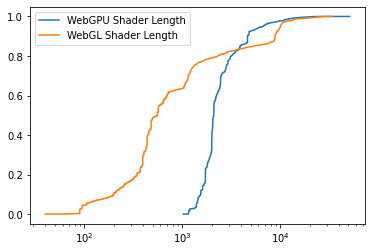

In [35]:
plt.plot(a, np.arange(len(a)) / len(a))
plt.plot(b, np.arange(len(b)) / len(b))
plt.xscale('log')
plt.legend(['WebGPU Shader Length', 'WebGL Shader Length'])